In [1]:
import torch
from torch import nn

## The Architecture

We are going to design a simple RNN using PyTorch.

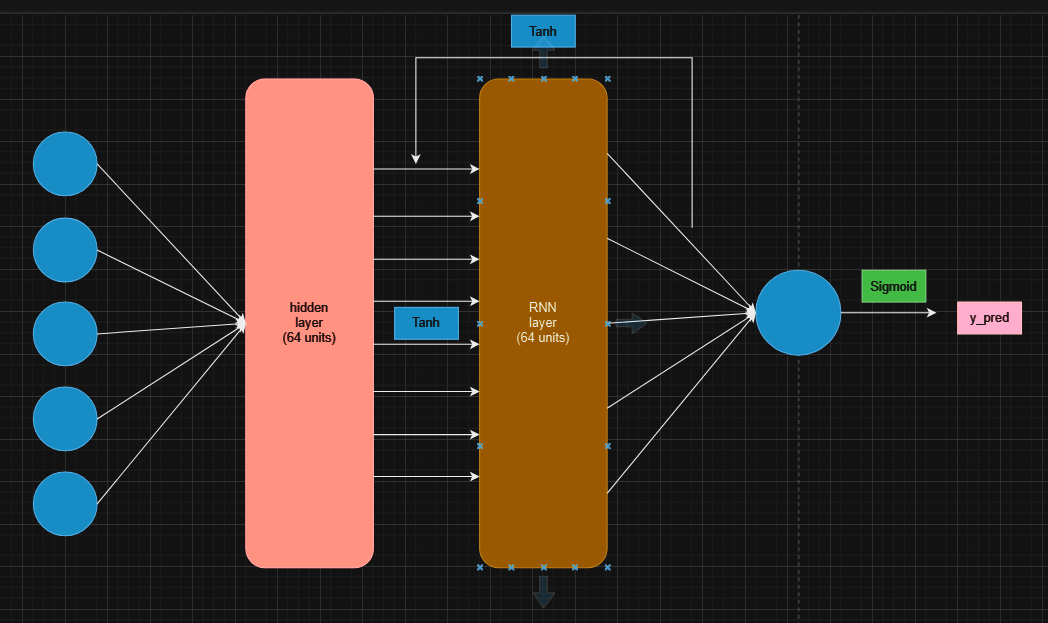

In [2]:
class MyRNN(nn.Module):
  def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
    super().__init__()
    self.input_layer = nn.Linear(in_features=input_shape, out_features=hidden_shape)
    self.rnn = nn.Linear(in_features=hidden_shape, out_features=hidden_shape)
    self.output_layer = nn.Linear(in_features=hidden_shape, out_features=output_shape)

    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):

    batch_size, seq_length, embedding_length = x.size()

    recur_hidden_state = torch.zeros( batch_size, self.rnn.in_features, device=x.device ) # This is the hidden state which will store the context from previous timesteps

    outputs = torch.zeros(batch_size, seq_length, self.output_layer.out_features, device=x.device)

    # Calculation of the output for each timestep
    for t in range(seq_length):
      input_at_t = x[:, t, :]
      z1 = self.tanh( self.input_layer(input_at_t) )

      recur_hidden_state = self.tanh( self.rnn(recur_hidden_state ) + z1)

      outputs[:, t, :] = self.output_layer( recur_hidden_state )

    final_output = self.sigmoid( outputs[:, -1, :] )
    return final_output

## Data

Since this is just a practice project, we will create a small dataset for sentiment analysis.

Positive comment: 1
Negative comment: 0

In [3]:
import pandas as pd

# Creating a list of comments with their corresponding sentiments
data = {
    'comment': [
        "The weather today is absolutely beautiful, and it's a perfect day to go outside.",
        "I had an amazing experience at the restaurant; the food was delicious and the service was impeccable.",
        "My new job has been a great opportunity, and I'm really excited about the projects I'll be working on.",
        "I just finished reading the book, and it was incredibly inspiring and motivating.",
        "Spending time with my family over the weekend was so refreshing and made me feel truly happy.",
        "I love how fast this phone performs; it's so smooth and responsive.",
        "The concert last night was amazing; the band played all my favorite songs.",
        "I can't believe how much I’ve learned in this course. The material is so interesting!",
        "The new software update made my device feel brand new again. Very impressed!",
        "I received excellent customer support when I had an issue with my order. Highly recommend!",

        "The traffic was terrible today, and it took forever to get to work.",
        "I’m really disappointed with the service at this store; the staff were rude and unhelpful.",
        "I’ve been feeling so stressed lately with all the deadlines piling up.",
        "The movie was a complete waste of time; it was boring and poorly made.",
        "I don’t understand why my computer keeps crashing; it’s been frustrating all day.",
        "I regret spending money on this product; it’s been nothing but trouble.",
        "The food at the restaurant was cold, and the service was extremely slow.",
        "I can't believe how awful my experience was at the hotel. The room was dirty and uncomfortable.",
        "The app is buggy and constantly crashes. Very frustrating to use.",
        "I had such a terrible experience with customer service. They didn’t resolve my issue at all."
    ],
    'sentiment': [
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1,  # Positive sentiments
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0   # Negative sentiments
    ]
}

# Creating the DataFrame
df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

# Displaying the dataframe
print(df)

                                              comment  sentiment
0   The weather today is absolutely beautiful, and...          1
1   I can't believe how much I’ve learned in this ...          1
2   The movie was a complete waste of time; it was...          0
3   I don’t understand why my computer keeps crash...          0
4   Spending time with my family over the weekend ...          1
5   I had an amazing experience at the restaurant;...          1
6   I just finished reading the book, and it was i...          1
7   I received excellent customer support when I h...          1
8   The concert last night was amazing; the band p...          1
9   I had such a terrible experience with customer...          0
10  My new job has been a great opportunity, and I...          1
11  The app is buggy and constantly crashes. Very ...          0
12  I’m really disappointed with the service at th...          0
13  The new software update made my device feel br...          1
14  I’ve been feeling so 

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
df['tokenized'] = df['comment'].apply(lambda x: x.lower().split())
df['tokenized']

,tokenized
0,"[the, weather, today, is, absolutely, beautifu..."
1,"[i, can't, believe, how, much, i’ve, learned, ..."
2,"[the, movie, was, a, complete, waste, of, time..."
3,"[i, don’t, understand, why, my, computer, keep..."
4,"[spending, time, with, my, family, over, the, ..."
5,"[i, had, an, amazing, experience, at, the, res..."
6,"[i, just, finished, reading, the, book,, and, ..."
7,"[i, received, excellent, customer, support, wh..."
8,"[the, concert, last, night, was, amazing;, the..."
9,"[i, had, such, a, terrible, experience, with, ..."


## Tokenization

For creating embeddings, we would use simple one hot encodings.

We can create these embeddings using PyTorch's inbuilt ` nn.functional.one_hot() `

In [5]:
def one_hot_encode_pytorch(comment, word_to_index, vocabulary_size):
    indices = [word_to_index[word] for word in comment if word in word_to_index]
    indices_tensor = torch.tensor(indices, dtype=torch.long)
    one_hot_tensor = nn.functional.one_hot(indices_tensor, num_classes=vocabulary_size).float()
    return one_hot_tensor

def one_hot_to_text(one_hot_tensor, index_to_word):
    indices = torch.argmax(one_hot_tensor, dim=1)
    words = [index_to_word[idx.item()] for idx in indices]
    return ' '.join(words)

In [6]:
all_words = [word for comment in df['tokenized'] for word in comment]
vocabulary = sorted(set(all_words))
word_to_index = {word: idx for idx, word in enumerate(vocabulary)}

index_to_word = {idx: word for word, idx in word_to_index.items()}

df['one_hot'] = df['tokenized'].apply(lambda x: one_hot_encode_pytorch(x, word_to_index, len(vocabulary)))

max_len = max([len(seq) for seq in df['one_hot'].values])
max_len

19

In [7]:
padded_X = []
for seq in df['one_hot'].values:
    seq_tensor = torch.tensor(seq)

    padded_seq = nn.functional.pad(seq_tensor, (0, 0, 0, max_len - seq_tensor.size(0)), value=0) # Pad the sequence

    padded_X.append(padded_seq)

<ipython-input-7-79c088cfe9c4>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  seq_tensor = torch.tensor(seq)


In [8]:
X = torch.stack(padded_X).float()
y = torch.tensor(df['sentiment'].values).float()

In [9]:
X, y

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [10]:
df[['comment', 'one_hot']].head()

,comment,one_hot
0,"The weather today is absolutely beautiful, and...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
1,I can't believe how much I’ve learned in this ...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
2,The movie was a complete waste of time; it was...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
3,I don’t understand why my computer keeps crash...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
4,Spending time with my family over the weekend ...,"[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."


In [11]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [12]:
from torch import optim

input_shape = len(vocabulary)
hidden_shape = 64
output_shape = 1

model = MyRNN(input_shape=input_shape, hidden_shape=hidden_shape, output_shape=output_shape)


criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

model

MyRNN(
  (input_layer): Linear(in_features=169, out_features=64, bias=True)
  (rnn): Linear(in_features=64, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
  (tanh): Tanh()
  (sigmoid): Sigmoid()
)

## Training Loop

In [13]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()

        outputs = model(inputs) # Forward pass

        loss = criterion(outputs.squeeze(), labels) # Compute loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs.squeeze() > 0.5).float()
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Backward pass
        loss.backward()

        # Optimization step
        optimizer.step()


    print(f"Correct predictions: {correct_predictions} out of {total_predictions}")
    accuracy = 100 * correct_predictions / total_predictions
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}, Accuracy: {accuracy}%")

Correct predictions: 10 out of 20
Epoch [1/10], Loss: 0.7042526364326477, Accuracy: 50.0%
Correct predictions: 10 out of 20
Epoch [2/10], Loss: 0.692658293247223, Accuracy: 50.0%
Correct predictions: 10 out of 20
Epoch [3/10], Loss: 0.6896789193153381, Accuracy: 50.0%
Correct predictions: 12 out of 20
Epoch [4/10], Loss: 0.6885530471801757, Accuracy: 60.0%
Correct predictions: 12 out of 20
Epoch [5/10], Loss: 0.6821086764335632, Accuracy: 60.0%
Correct predictions: 17 out of 20
Epoch [6/10], Loss: 0.6741755604743958, Accuracy: 85.0%
Correct predictions: 20 out of 20
Epoch [7/10], Loss: 0.6585391879081726, Accuracy: 100.0%
Correct predictions: 20 out of 20
Epoch [8/10], Loss: 0.6182661652565002, Accuracy: 100.0%
Correct predictions: 20 out of 20
Epoch [9/10], Loss: 0.47443331480026246, Accuracy: 100.0%
Correct predictions: 20 out of 20
Epoch [10/10], Loss: 0.2711707174777985, Accuracy: 100.0%


In [14]:
# Example of converting the first input
sample_input = X[0]  # Assuming this is one-hot encoded
sample_text = one_hot_to_text(sample_input, index_to_word)

sample_input = X[0].unsqueeze(0)
sample_output = model(sample_input)

predicted_class = (sample_output.squeeze() > 0.5).float()
print(f"Predicted class for `{sample_text}`: {predicted_class.item()}")


Predicted class for `the weather today is absolutely beautiful, and it's a perfect day to go outside. a a a a a`: 1.0


In [15]:
# Example of converting the first input
sample_input = X[12]  # Assuming this is one-hot encoded
sample_text = one_hot_to_text(sample_input, index_to_word)

sample_input = X[12].unsqueeze(0)
sample_output = model(sample_input)

predicted_class = (sample_output.squeeze() > 0.5).float()
print(f"Predicted class for `{sample_text}`: {predicted_class.item()}")

Predicted class for `i’m really disappointed with the service at this store; the staff were rude and unhelpful. a a a a`: 0.0
